# Predicting the next word
Menghasilkan teks baru yang mengikuti teks awal yang diberikan, dengan menggunakan model bahasa untuk memprediksi kata-kata berikutnya berdasarkan konteksnya.





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

Saya menggunakan dataset [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), berisi lebih dari 2000 baris text dari Shakespeare's sonnets.

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 120MB/s]


In [5]:
# Mendefinisikan path untuk file soneta
SONNETS_FILE = './sonnets.txt'

# Membaca data
with open('./sonnets.txt') as f:
    data = f.read()

# Mengonversi ke huruf kecil dan menyimpan sebagai daftar
corpus = data.lower().split("\n")

print(f"Ada {len(corpus)} baris soneta\n")
print(f"5 baris pertama terlihat seperti ini:\n")
for i in range(5):
  print(corpus[i])

Ada 2159 baris soneta

5 baris pertama terlihat seperti ini:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,



## Tokenisasi Teks

Sekarang, pasangkan Tokenizer ke dalam korpus dan simpan total jumlah kata.



In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

Ketika mengonversi teks menjadi urutan, dapat menggunakan metode texts_to_sequences
Contoh pertama dari korpus adalah sebuah string dan terlihat seperti ini:

In [7]:
corpus[0]

'from fairest creatures we desire increase,'

In [8]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

Perhatikan bahwa menerima urutan yang dibungkus dalam sebuah daftar, jadi untuk mendapatkan hanya urutan yang diinginkan,  perlu secara eksplisit mengambil item pertama dalam daftar seperti ini:

In [9]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

##Menghasilkan n-gram

 Fungsi ini menerima tokenizer yang telah disesuaikan dan korpus (yang merupakan daftar string) dan seharusnya mengembalikan daftar yang berisi urutan n-gram untuk setiap baris dalam korpus:

In [10]:
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]

        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i + 1]
            input_sequences.append(n_gram_sequence)

    return input_sequences

In [12]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("Urutan n-gram untuk contoh pertama terlihat seperti ini:\n")
first_example_sequence

Urutan n-gram untuk contoh pertama terlihat seperti ini:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [13]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("Urutan n-gram untuk 3 contoh berikut terlihat seperti ini:\n")
next_3_examples_sequence

Urutan n-gram untuk 3 contoh berikut terlihat seperti ini:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Terapkan transformasi n_gram_seqs ke seluruh korpus dan simpan panjang urutan maksimum untuk digunakan nanti:

In [14]:
# Terapkan transformasi n_gram_seqs ke seluruh korpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Simpan panjang maksimum
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n-gram dari input_sequences memiliki panjang: {len(input_sequences)}")
print(f"Panjang maksimum dari urutan adalah: {max_sequence_len}")


n-gram dari input_sequences memiliki panjang: 15462
Panjang maksimum dari urutan adalah: 11


## Menambahkan Padding pada Urutan

In [15]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen = maxlen))
    return padded_sequences

In [16]:
# Uji fungsi dengan n-gram urutan dari contoh pertama
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq


array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [17]:
# Uji fungsi dengan n-gram urutan dari 3 contoh berikutnya
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq


array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [18]:
# Melakukan padding ke seluruh korpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"Korpus yang telah dipadati memiliki bentuk: {input_sequences.shape}")


Korpus yang telah dipadati memiliki bentuk: (15462, 11)



##Memisahkan Data menjadi Fitur dan Label
Sebelum memberi data ke neural network, perlu memisahkan data tersebut menjadi fitur dan label. Dalam kasus ini, fitur akan menjadi urutan n-gram yang telah dipadati dengan menghapus kata terakhir dari urutan tersebut, dan label akan menjadi kata yang dihapus.

fungsi features_and_labels di bawah ini. Fungsi ini mengharapkan urutan n-gram yang telah dipadati sebagai input dan seharusnya mengembalikan tuple yang berisi fitur dan label yang telah di-one-hot encode.

In [19]:
def features_and_labels(input_sequences, total_words):

    features = input_sequences[:, :-1]
    labels = input_sequences[:, -1]
    one_hot_labels = to_categorical(labels, num_classes = total_words)

    return features, one_hot_labels

In [20]:
# Uji fungsi dengan urutan n-gram yang telah dipadati dari contoh pertama
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"Label memiliki bentuk: {first_labels.shape}")
print("\nFitur terlihat seperti ini:\n")
first_features


Label memiliki bentuk: (5, 3211)

Fitur terlihat seperti ini:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [21]:
# Pisahkan seluruh korpus
fitur, label = features_and_labels(input_sequences, total_words)

print(f"Fitur memiliki bentuk: {fitur.shape}")
print(f"Label memiliki bentuk: {label.shape}")


Fitur memiliki bentuk: (15462, 10)
Label memiliki bentuk: (15462, 3211)


##Membuat Model
Neural Networl LSTM tipe jaringan saraf rekuren yang cocok untuk pemrosesan urutan data, seperti teks.

In [22]:
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation = 'softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [23]:
# Dapatkan model yang belum dilatih
model = create_model(total_words, max_sequence_len)

# Latih model
history = model.fit(fitur, label, epochs=50, verbose=1)


Epoch 1/50
484/484 [==============================] - 36s 65ms/step - loss: 6.8877 - accuracy: 0.0233
Epoch 2/50
484/484 [==============================] - 29s 59ms/step - loss: 6.4191 - accuracy: 0.0294
Epoch 3/50
484/484 [==============================] - 29s 61ms/step - loss: 6.1907 - accuracy: 0.0400
Epoch 4/50
484/484 [==============================] - 32s 66ms/step - loss: 5.9410 - accuracy: 0.0519
Epoch 5/50
484/484 [==============================] - 30s 61ms/step - loss: 5.6538 - accuracy: 0.0619
Epoch 6/50
484/484 [==============================] - 30s 62ms/step - loss: 5.3071 - accuracy: 0.0755
Epoch 7/50
484/484 [==============================] - 30s 61ms/step - loss: 4.9192 - accuracy: 0.0936
Epoch 8/50
484/484 [==============================] - 30s 62ms/step - loss: 4.5127 - accuracy: 0.1218
Epoch 9/50
484/484 [==============================] - 30s 62ms/step - loss: 4.1074 - accuracy: 0.1717
Epoch 10/50
484/484 [==============================] - 29s 59ms/step - loss: 3.708

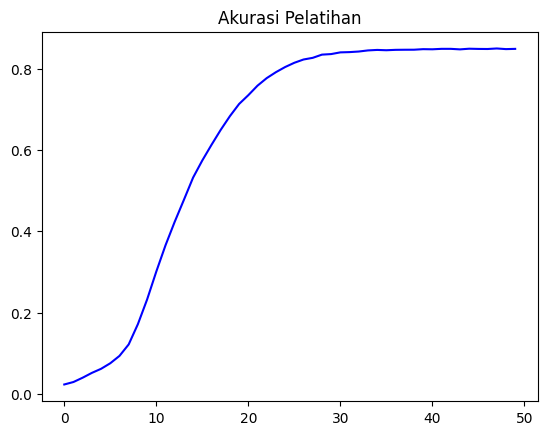

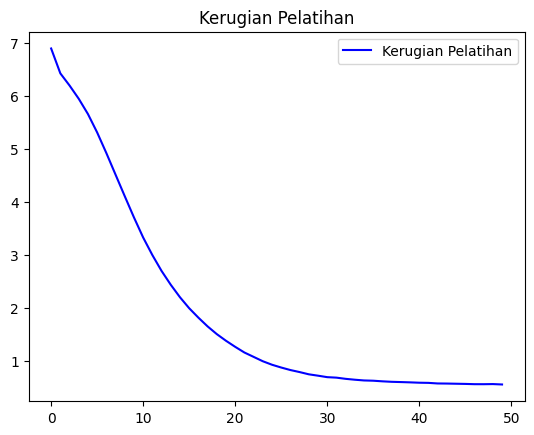

In [24]:
import matplotlib.pyplot as plt

akurasi = history.history['accuracy']
kerugian = history.history['loss']

epoch = range(len(akurasi))

plt.plot(epoch, akurasi, 'b', label='Akurasi Pelatihan')
plt.title('Akurasi Pelatihan')

plt.figure()

plt.plot(epoch, kerugian, 'b', label='Kerugian Pelatihan')
plt.title('Kerugian Pelatihan')
plt.legend()

plt.show()


##Lihat Model untuk prediksi kata
melihat model menghasilkan teks.
Jalankan sel di bawah ini untuk menghasilkan 100 kata berikutnya dari teks awal.

In [28]:
seed_text = "From fairest creatures we desire increase"
kata_selanjutnya = 100

for _ in range(kata_selanjutnya):
    # Mengonversi teks menjadi urutan
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Melakukan padding pada urutan
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Mendapatkan probabilitas memprediksi sebuah kata
    predicted = model.predict(token_list, verbose=0)
    # Memilih kata selanjutnya berdasarkan probabilitas maksimum
    predicted = np.argmax(predicted, axis=-1).item()
    # Mendapatkan kata sebenarnya dari indeks kata
    output_word = tokenizer.index_word[predicted]
    # Menambahkan ke teks saat ini
    seed_text += " " + output_word

print(seed_text)


From fairest creatures we desire increase cry shows now heart thence it swear thee none near call good date heir me in head done done shall hate none none ranks true heart in fortune so call ' ' me none had knows me not not that can heart so heart of thee head me in thee is i love well admitted new live bright ' with friend art poor blessed see tripping less of her growth to thee it bright alone else so bold in truth ' have erred much near assured thee and thine eyes me bright ' ' with this art and in my
